In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1 - A

In [29]:
from statistics import mode

class KNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.points = X
        self.labels = y

    def _minkowski(self, vector, p=3):
        return np.sum(np.abs(self.points - vector) ** p, axis=1) ** (1 / p)
    
    def _euclidean(self, vector):
        return self._minkowski(vector, p=2)

    def _manhattan(self, vector):
        return np.sum(np.abs(self.points - vector), axis=1)

    def predict(self, vector, metric="euclidean"):
        if metric == "minkowski": 
            f = self._minkowski
        elif metric == "manhattan": 
            f = self._manhattan
        else:
            f = self._euclidean
        
        distances = f(vector)
        neighbors = distances.argsort()[:self.k]
        return mode(self.labels[neighbors])

In [30]:
path = "data/data08_1.csv"
df = pd.read_csv(path)

X = df[["weight", "sweetness"]].to_numpy()
y = df["label"].to_numpy()

In [31]:
knn = KNN()
knn.fit(X, y)

test_vector = [165, 5.5]
print("Euclidean\n", knn._euclidean(test_vector))
print("Minkowski\n", knn._minkowski(test_vector))
print("Manhattan\n", knn._manhattan(test_vector))

knn.predict(test_vector, metric="manhattan")

Euclidean
 [15.07481343 35.00357125 15.07481343  5.02493781  5.02493781 25.12468905]
Minkowski
 [15.00499833 35.00003401 15.00499833  5.00166611  5.00166611 25.00833056]
Manhattan
 [16.5 35.5 16.5  5.5  5.5 27.5]


'apple'

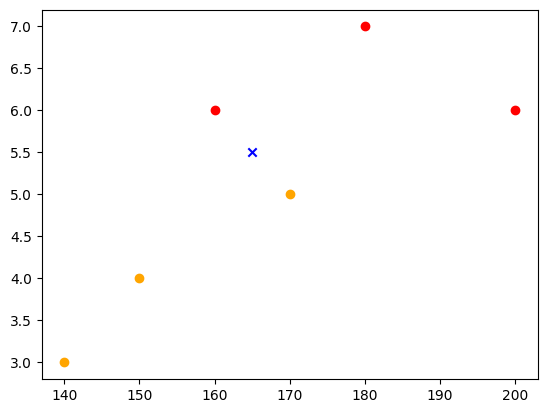

In [232]:
plt.figure()

for weight, sweetness, label in df.values:
    color = 'red' if label == 'apple' else 'orange'
    plt.scatter(weight, sweetness, color=color)

plt.scatter(*test_vector, color="blue", marker="x")

### 1 - B

In [233]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()), 
        ("knn", KNeighborsClassifier(n_neighbors=3))
])

knn = pipeline.fit(X, y)

In [234]:
test_vector = np.array([[165, 5.5]])
pipeline.predict(test_vector)

array(['apple'], dtype=object)

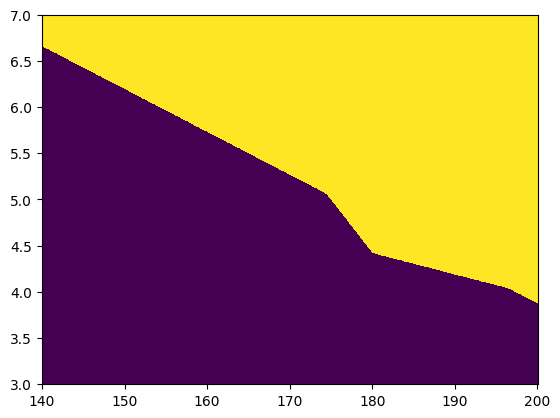

In [235]:
n = 1000

x0, x1 = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), n),
    np.linspace(X[:, 1].min(), X[:, 1].max(), n)
)

Z = pipeline.predict(np.c_[x0.ravel(), x1.ravel()])
Z = Z.reshape(x0.shape)
Z = np.vectorize(lambda x: 1 if x == "apple" else 0)(Z)

plt.figure()
plt.pcolormesh(x0, x1, Z)

### 2 - A

In [236]:
from collections import defaultdict

def entropy(series):
    """Returs the entropy of a single DataFrame column (Series object).

    Example usage:
    >>> entropy(df['age'])
    """
    _, counts = np.unique(series, return_counts=True)
    n = sum(counts)

    result = 0
    for count in counts:
        p = count / n
        result -= p * np.log2(p)
    
    return result


def information_gain(df, split_col):
    """Returns the information gain accrued from splitting along a column.
    
    Example usage:
    >>> information_gain(df, 'age')
    """
    keys, counts = np.unique(df[split_col], return_counts=True)
    n = sum(counts)

    new_entropy = 0
    for i, x in enumerate(keys):
        new_entropy += (counts[i] / n) * entropy(df[df[split_col] == x].iloc[:, -1])
    
    return entropy(df.iloc[:, -1]) - new_entropy


def build_decision_tree(df):
    if len(np.unique(df.iloc[:, -1])) == 1:
        return df.iloc[0, -1]
    
    if len(df.columns) == 1:
        return df.iloc[:, -1].mode()[0]
    
    best_col, best_gain = None, 0

    for col in df.columns[:-1]:
        gain = information_gain(df, col)

        if gain >= best_gain:
            best_col, best_gain = col, gain
    
    tree = defaultdict(None)
    for value in np.unique(df[best_col]):
        subset = df[df[best_col] == value].drop(best_col, axis=1)
        tree[value] = build_decision_tree(subset)
        tree["column_name"] = best_col
    
    return tree


def predict(root: dict, D: dict):
    node = root
    while isinstance(node, dict):
        col = node["column_name"]
        node = node[D[col]]
    return node

In [237]:
path = "data/data08_2.csv"
df = pd.read_csv(path)
tree = build_decision_tree(df)

D = {'age': 50, 'bp': 'low', 'cholesterol': 'high'}
predict(tree, D)

'sick'

### 2 - B

In [238]:
df['bp'] = df['bp'].map({'high': 1, 'low': 0})
df['cholesterol'] = df['cholesterol'].map({'high': 1, 'normal': 0})
df['diagnosis'] = df['diagnosis'].map({'sick': 1, 'healthy': 0})
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [245]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X, y)

X_test = pd.DataFrame([[50, 0, 1]], columns=X.columns) # age, bp, cholesterol
clf.predict(X_test)

array([1])